CUDA Pitch finder.
-------
Implementing a piece of the algorithm to find pitch from the paper. _A SMARTER WAY TO FIND PITCH_ by Philip McLeod, Geoff Wyvill, University of Otago Department of Computer Science http://miracle.otago.ac.nz/tartini/papers/A_Smarter_Way_to_Find_Pitch.pdf

The piece we're implementing is the Normalized Square Difference Function.  The value of the highest peak of the "tau" value is releated to the fundamental frequency of the sound being analyzed (frequency = sample_rate / tau).  More needs to be done to make this useful, but this is a significant part of the algorithm to find the pitch.

I was quite surprised by the CUDA speedup.  I knew it would be faster, but wasn't expecting 10,000x!  When I first tried this, I got 15 seconds to process a 0.25s sample in python.  Then, in CUDA it was 1.5ms!  Wow!

October, 2017

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import math

from numba import cuda

In [2]:
# first, try doing this in python & numpy
def get_all_nsdf(x,max_tau=1024,W=2048):
    print("This can take around a minute to process 1 second of audio.  Be patient.")
    xx = np.concatenate([np.zeros(W),x,np.zeros(W)])
    all_nsdf = np.zeros((1+x.shape[0]//(W//2),max_tau))
    for i,s in enumerate(range(0,x.shape[0],W//2)):
        ii = s+W
        for tau in range(0,max_tau):
            r = 0.0
            m = 0.0
            # I believe there is probably a better way to do this in numpy
            # but I'm no numpy expert.  Suggestions appreciated.
            for j in range(ii-(W-tau)//2,ii+(W-tau)//2):
                r += (xx[j]*xx[j+tau])
                m += xx[j]*xx[j] + xx[j+tau]*xx[j+tau]
            d = 2*r/m
            all_nsdf[i][tau] = d
    return all_nsdf

# convert the above code to CUDA & see if that is any better
@cuda.jit
def get_nsdf_cuda(result,signal,W):
    gx, gy = cuda.grid(2)
    if gx < result.shape[0] and gy < result.shape[1]:
        result_index = gx
        tau = gy
        max_tau = result.shape[1]
        signal_index = (2 + result_index)*(W//2)
        r = 0.0
        m = 0.0
        for j in range(signal_index-(W-tau)//2,signal_index+(W-tau)//2):
            r += (signal[j]*signal[j+tau])
            m += signal[j]*signal[j] + signal[j+tau]*signal[j+tau]
        d = 2*r/m
        result[gx, gy] = d

def get_all_nsdf_cuda(x,tpb,max_tau=1024,W=2048):
    padded_signal = np.concatenate([np.zeros(W, dtype=np.float32),x,np.zeros(W, dtype=np.float32)])
    # sample with 50% overlap
    nsdf_samples = (x.shape[0]+(W//2))//(W//2)
    all_nsdf = np.zeros((nsdf_samples,max_tau), dtype=np.float32)
    threads_per_block = tpb
    blocks_per_grid = ((all_nsdf.shape[0] + (threads_per_block[0] - 1)) // threads_per_block[0],
                       (all_nsdf.shape[1] + (threads_per_block[1] - 1)) // threads_per_block[1])
    get_nsdf_cuda[blocks_per_grid, threads_per_block](all_nsdf,padded_signal,W)
    return all_nsdf

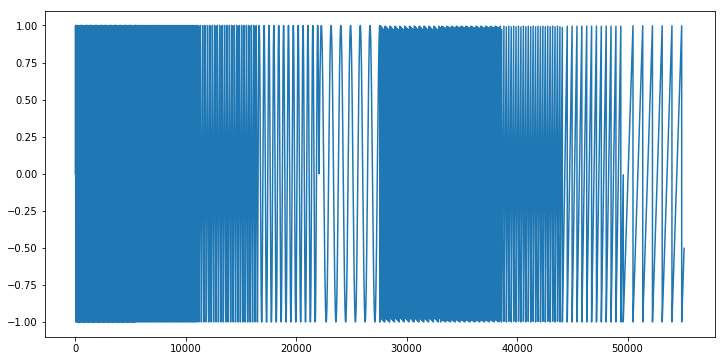

In [3]:
# create signal to play with
len_in_sec = 0.125
samp_per_sec = 44100
samp = int(samp_per_sec * len_in_sec)
freq = 300.0 # Hz
s = np.arange(samp) # sample #
t = s/samp_per_sec  # time
xr = np.concatenate([np.sin(2*np.pi*800*t),
                     np.sin(2*np.pi*400*t),
                     np.sin(2*np.pi*200*t),
                     np.sin(2*np.pi*100*t),
                     np.sin(2*np.pi*50*t),
                     signal.sawtooth(2*np.pi*800*t),
                     signal.sawtooth(2*np.pi*400*t),
                     signal.sawtooth(2*np.pi*200*t),
                     signal.sawtooth(2*np.pi*100*t),
                     signal.sawtooth(2*np.pi*50*t)
                    ])
plt.figure(figsize=(12,6))
plt.plot(xr)

In [4]:
%%time
# First, try it in python.  This takes ~1 minute for the 1.25s sample.
r = get_all_nsdf(xr)

This can take around a minute to process 1 second of audio.  Be patient.
CPU times: user 1min 19s, sys: 7.54 ms, total: 1min 19s
Wall time: 1min 19s


In [5]:
%%time
# Now, try it in CUDA.  This should be << 1 second--including compliation time!
r_cuda = get_all_nsdf_cuda(xr,(4,64))

CPU times: user 202 ms, sys: 104 ms, total: 306 ms
Wall time: 1.1 s


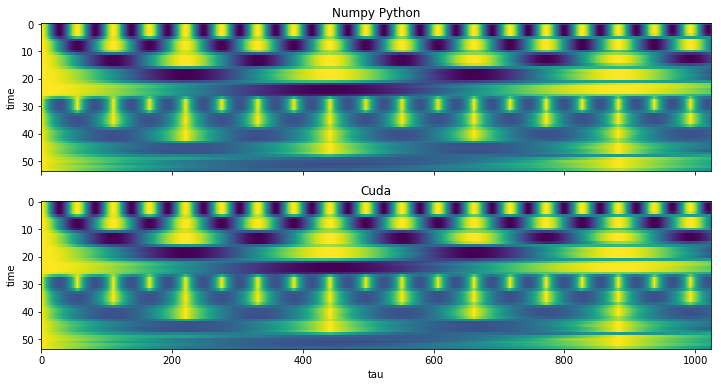

In [6]:
# check the results
f, axs = plt.subplots(2, sharex=True, figsize=(12,6))
axs[0].set_ylabel("time")
axs[0].imshow(r,aspect='auto')
axs[0].set_title("Numpy Python")
axs[1].set_xlabel("tau")
axs[1].set_ylabel("time")
axs[1].imshow(r_cuda,aspect='auto')
axs[1].set_title("Cuda")

In [7]:
%%timeit
# can try other block sizes, too
r_cuda = get_all_nsdf_cuda(xr,(4,64))

100 loops, best of 3: 4.3 ms per loop


In [8]:
python_time = 1*60+17
cuda_time = 0.00429
print("speedup = %.0f !!!"%(python_time / cuda_time))

speedup = 17949 !!!
